In [1]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import datetime
import time
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import classification_report, recall_score,confusion_matrix,roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn import metrics
from numpy import argmax, argmin


C:\Users\Rory\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#reading raw data from csv
rawdata=pd.read_csv('C:/Users/Rory/Downloads/carInsurance_train.csv',index_col = 'Id')

In [3]:

#not interested in this column
pdata=rawdata.drop(["Communication"], axis=1)

In [4]:
#Filling missing data
pdata['Job'] = pdata['Job'].fillna(method ='pad')
pdata['Education'] = pdata['Education'].fillna(method ='pad')
pdata['Outcome'] = pdata['Outcome'].fillna('none')
pdata.isnull().sum()

Age                 0
Job                 0
Marital             0
Education           0
Default             0
Balance             0
HHInsurance         0
CarLoan             0
LastContactDay      0
LastContactMonth    0
NoOfContacts        0
DaysPassed          0
PrevAttempts        0
Outcome             0
CallStart           0
CallEnd             0
CarInsurance        0
dtype: int64

In [5]:
#Creating a column which holds the duration of the call
pdata['CallEnddt']=pd.to_datetime(pdata['CallEnd'],format= '%H:%M:%S' )
pdata['CallStartdt']=pd.to_datetime(pdata['CallStart'],format= '%H:%M:%S' )
pdata['CallDur']=(pdata['CallEnddt']-pdata['CallStartdt']).dt.total_seconds()
pdata.drop(columns=['CallStartdt','CallEnddt'])

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance,CallDur
Id,,,,,,,,,,,,,,,,,,
1,32,management,single,tertiary,0,1218,1,0,28,jan,2,-1,0,none,13:45:20,13:46:30,0,70.0
2,32,blue-collar,married,primary,0,1156,1,0,26,may,5,-1,0,none,14:49:03,14:52:08,0,185.0
3,29,management,single,tertiary,0,637,1,0,3,jun,1,119,1,failure,16:30:24,16:36:04,1,340.0
4,25,student,single,primary,0,373,1,0,11,may,2,-1,0,none,12:06:43,12:20:22,1,819.0
5,30,management,married,tertiary,0,2694,0,0,3,jun,1,-1,0,none,14:35:44,14:38:56,0,192.0
6,32,technician,single,tertiary,0,1625,0,0,22,may,1,109,1,failure,14:58:08,15:11:24,1,796.0
7,37,admin.,single,tertiary,0,1000,1,0,17,mar,1,-1,0,none,13:00:02,13:03:17,1,195.0
8,35,management,divorced,tertiary,0,538,1,0,12,may,4,-1,0,none,15:39:43,15:40:49,0,66.0
9,30,admin.,married,secondary,0,187,1,0,18,nov,1,-1,0,none,12:20:56,12:22:42,0,106.0


In [6]:
#Detecting outliers using Z-score, values with a Z-score over 10 are outliers
outliers=[]
def detect_outlier(data_1):
    
    threshold=10
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [7]:
outliers=[]
detect_outlier(pdata['CallDur'])
print(outliers)
outliers=[]
detect_outlier(pdata['Balance'])
print(outliers)

[]
[52587, 37127, 36686, 98417, 38279, 45248, 43074]


Text(0.5,1,'Pre-outlier removal')

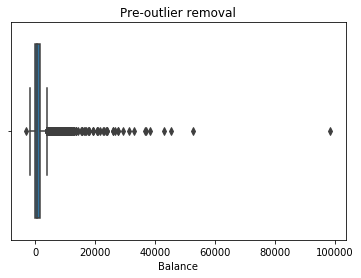

In [8]:
sns.boxplot(x="Balance", data=pdata).set_title('Pre-outlier removal')

Text(0.5,1,'Post-outlier removal')

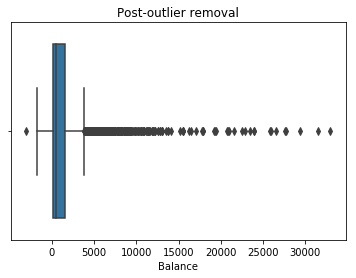

In [9]:
#Removing outliers
for i in outliers:
    indexName = pdata[ pdata['Balance'] == i ].index
    pdata.drop(indexName , inplace=True)
    
sns.boxplot(x="Balance", data=pdata).set_title('Post-outlier removal')


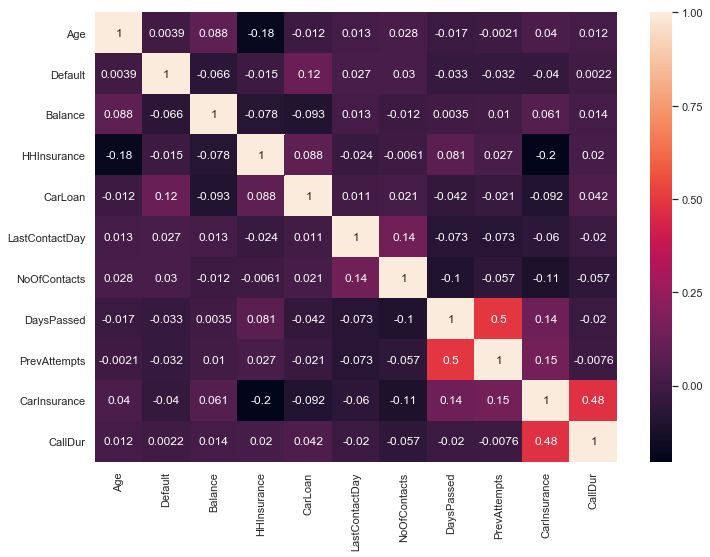

In [10]:
#Finding correlation between variables
heatmapcorr=pdata.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(heatmapcorr, annot=True)

C:\Users\Rory\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Call Duration Histogram')

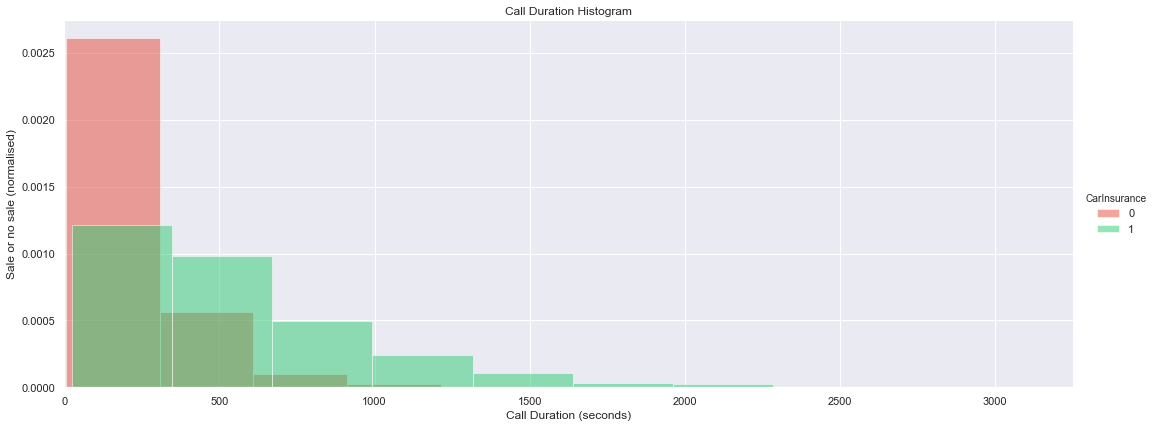

In [11]:
#Call duration and car insurance purchase histagram
histpal=["#e74c3c", "#2ecc71"]
facet= sns.FacetGrid(pdata, hue='CarInsurance', size=6, aspect =2.5, palette= histpal)
facet.map(plt.hist, 'CallDur', bins=10, alpha=0.5,  normed=True)
facet.set(xlim=(0,pdata.CallDur.max()))
facet.add_legend()
plt.xlabel('Call Duration (seconds)')
plt.ylabel('Sale or no sale (normalised)')
plt.title('Call Duration Histogram')

C:\Users\Rory\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.5, 6, 0.0, 2091.6)

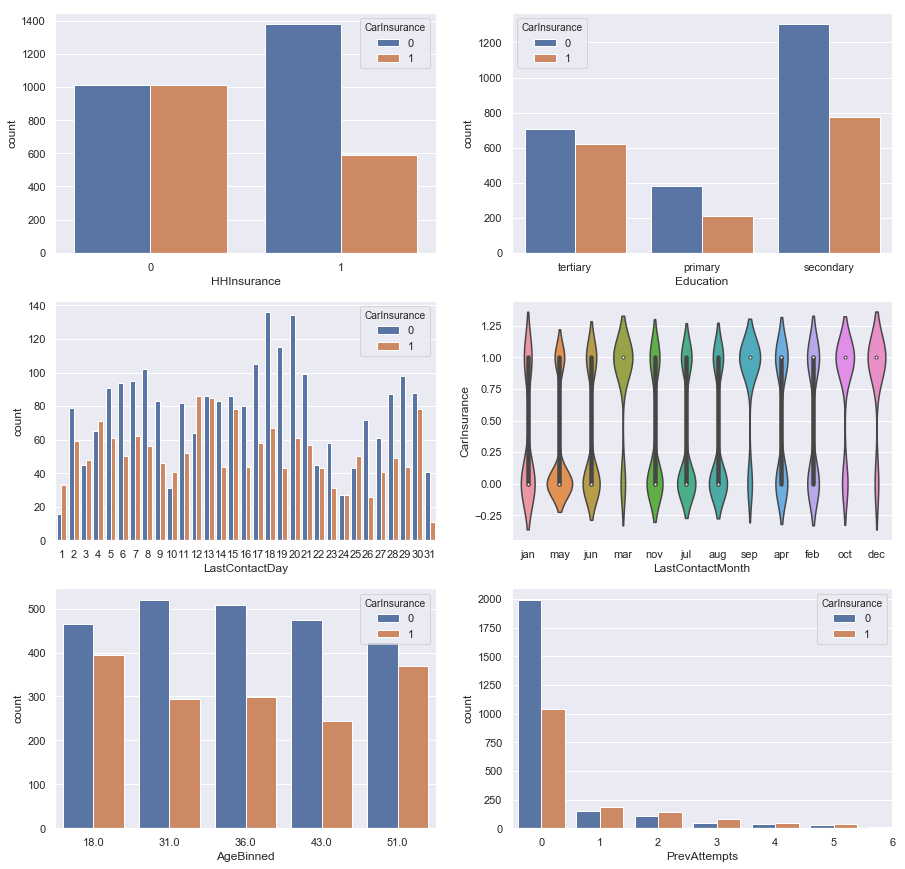

In [12]:
f, axes= plt.subplots(3,2, figsize=(15,15))
sns.countplot(x='Education', hue='CarInsurance', data=pdata, ax=axes[0,1])
sns.countplot(x='HHInsurance', hue='CarInsurance', data=pdata, ax=axes[0,0])
sns.violinplot(x="LastContactMonth",y='CarInsurance',data=pdata, ax=axes[1,1])
agelabels=np.quantile(pdata['Age'],[0,0.2,0.4,0.6,0.8,1])
pdata['AgeBinned'] = pd.qcut(pdata['Age'], 5 , labels = agelabels[0:5])
sns.countplot(x='AgeBinned', hue='CarInsurance', data=pdata, ax=axes[2,0])
sns.countplot(x='LastContactDay', hue='CarInsurance' , data=pdata ,ax=axes[1,0])
sns.countplot(x='PrevAttempts', hue='CarInsurance' , data=pdata ,ax=axes[2,1])
axes[2,1].axis(xmax=6)

In [13]:
pdata['Age'].describe()

count    3993.000000
mean       41.194841
std        11.536498
min        18.000000
25%        32.000000
50%        39.000000
75%        49.000000
max        95.000000
Name: Age, dtype: float64

In [14]:
df=pdata
df['CDfiv']=pd.qcut(df['CallDur'], q=5, labels=False)
df['BalanceBinned'] = pd.qcut(df['Balance'], 5,labels = False)
sns.countplot(x='AgeBinned', hue='CarInsurance', data=df)

In [18]:
df_n=df

In [19]:
df_n.drop(['Age','Balance','CallStart','CallEnd','CallDur'],axis = 1,inplace = True)

In [20]:
Job = pd.get_dummies(data = df_n['Job'],prefix = "Job")
Marital= pd.get_dummies(data = df_n['Marital'],prefix = "Marital")
Education= pd.get_dummies(data = df_n['Education'],prefix="Education")

LastContactMonth = pd.get_dummies(data = df_n['LastContactMonth'],prefix= "LastContactMonth")
Outcome = pd.get_dummies(data = df_n['Outcome'],prefix = "Outcome")

In [21]:
df_n.drop(['Job','Marital','Education','LastContactMonth','Outcome','CallEnddt','CallStartdt'],axis=1,inplace=True)

In [22]:
df = pd.concat([df_n,Job,Marital,Education,LastContactMonth,Outcome],axis=1)

In [23]:
X= df.drop(['CarInsurance'],axis=1).values
# Including only the Target for y
y=df['CarInsurance'].values
#Splitting the Training and Testing data having 20% of Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42, stratify = y)


In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Using Success and Failure for 0 and 1    
class_names = ['Success','Failure']

In [25]:

#Finding the optimal value of neighbours
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print(argmax(mean_acc))
print(argmin(std_acc))
print("5 neighbours has the lowest error")

2
2
5 neighbours has the lowest error


Standard Deviation= 0.0159
             precision    recall  f1-score   support

          0       0.74      0.82      0.78       478
          1       0.68      0.56      0.62       321

avg / total       0.71      0.72      0.71       799



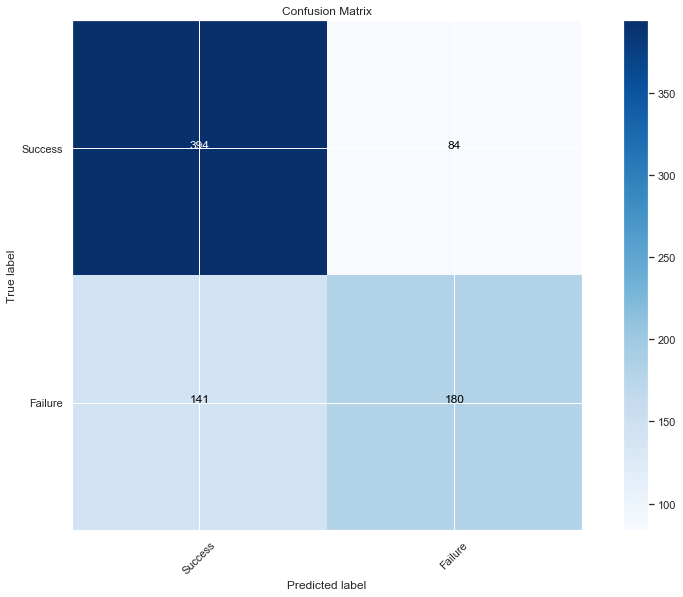

In [26]:
#Kneighbor with n=5
neigh=KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
kn_yhat=neigh.predict(X_test)

#Standard dev
std=np.std(kn_yhat==y_test)/np.sqrt(kn_yhat.shape[0])
print("Standard Deviation= %2.4f"% std)
#Classification report
class_kn=classification_report(y_test, kn_yhat)
print(class_kn)
#Confusion matrix
cm_kn=confusion_matrix(y_test,kn_yhat)
plot_confusion_matrix(cm_kn, classes=class_names, title='Confusion Matrix')

Standard Deviation= 0.0131


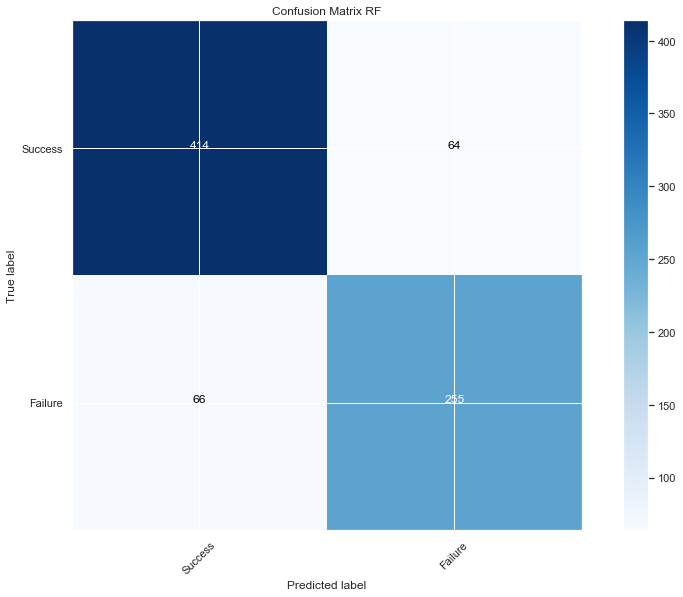

In [27]:
#from sklearn import RandomForestClassifier
#Random Forest
forest=RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10, class_weight="balanced").fit(X_train, y_train)
rf_yhat=forest.predict(X_test)
std=np.std(rf_yhat==y_test)/np.sqrt(rf_yhat.shape[0])
print("Standard Deviation= %2.4f"% std)
class_forest=classification_report(y_test, rf_yhat)
cm_forest=confusion_matrix(y_test,rf_yhat)
plot_confusion_matrix(cm_forest, classes=class_names, title='Confusion Matrix RF')

Standard Deviation= 0.0136


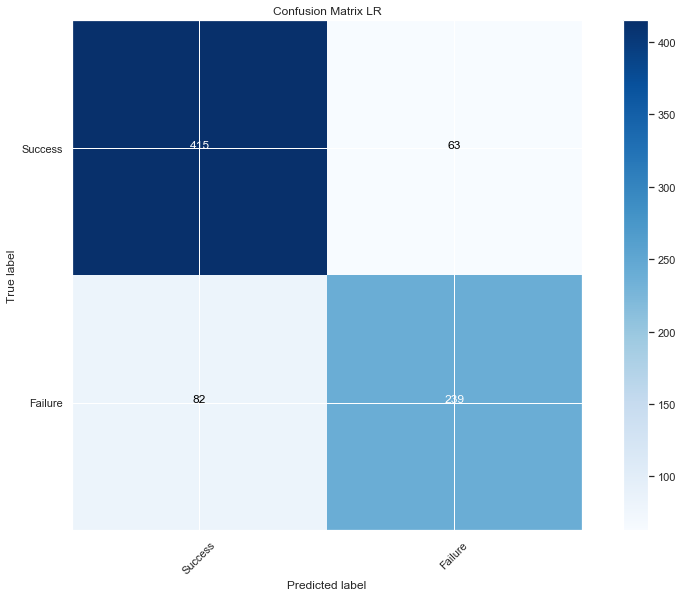

In [28]:
#Logistic Regression
lr=LogisticRegression().fit(X_train, y_train)
lr_yhat=lr.predict(X_test)
std=np.std(lr_yhat==y_test)/np.sqrt(lr_yhat.shape[0])
print("Standard Deviation= %2.4f"% std)
class_lr=classification_report(y_test, lr_yhat)
cm_lr=confusion_matrix(y_test,lr_yhat)
plot_confusion_matrix(cm_lr, classes=class_names, title='Confusion Matrix LR')

Standard Deviation= 0.0130


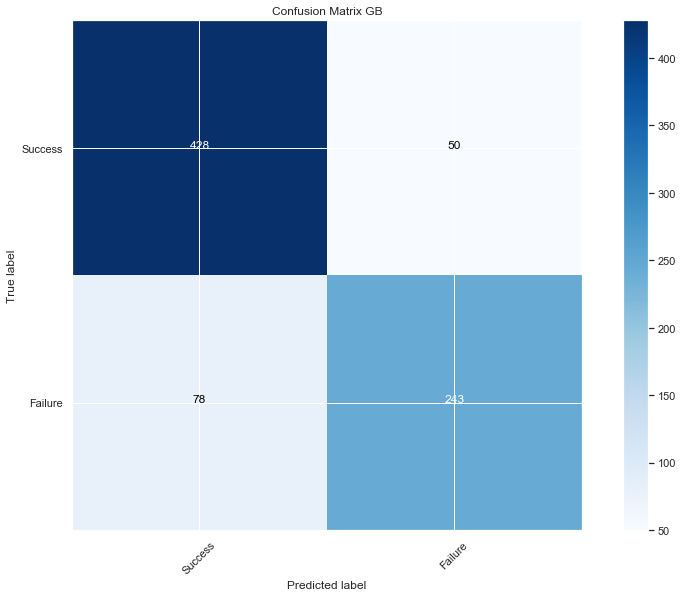

In [29]:
#Gradient Boost
gb=GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01).fit(X_train, y_train)
gb_yhat=gb.predict(X_test)
std=np.std(gb_yhat==y_test)/np.sqrt(gb_yhat.shape[0])
print("Standard Deviation= %2.4f"% std)
class_gb=classification_report(y_test, gb_yhat)
cm_gb=confusion_matrix(y_test,gb_yhat)
plot_confusion_matrix(cm_gb, classes=class_names, title='Confusion Matrix GB')

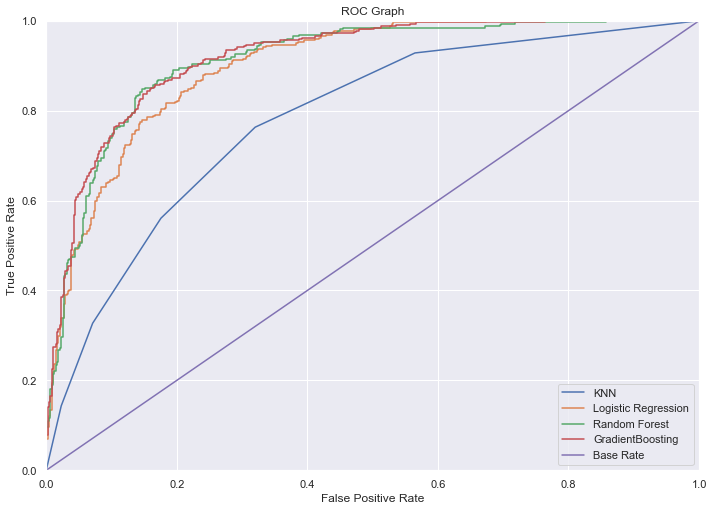

In [30]:
#ROC curve - from manibhask on kaggle
#Obtaining False Positive Rate, True Positive Rate and Threshold for all classifiers
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
forest_fpr, forest_tpr, thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
gb_fpr, gb_tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
#PLotting ROC Curves for all classifiers
plt.plot(knn_fpr, knn_tpr, label='KNN' )
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.plot(forest_fpr, forest_tpr, label='Random Forest')
plt.plot(gb_fpr, gb_tpr, label='GradientBoosting')
#Plot Base Rate ROC
plt.plot([0,1],[0,1],label='Base Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()


In [31]:
#Classification reports
print("K-nearest Neighbor")
print(class_kn)
print("Random Forest")
print(class_forest)
print("Logistic Regression")
print(class_lr)
print("Gradient Booster")
print(class_gb)

K-nearest Neighbor
             precision    recall  f1-score   support

          0       0.74      0.82      0.78       478
          1       0.68      0.56      0.62       321

avg / total       0.71      0.72      0.71       799

Random Forest
             precision    recall  f1-score   support

          0       0.86      0.87      0.86       478
          1       0.80      0.79      0.80       321

avg / total       0.84      0.84      0.84       799

Logistic Regression
             precision    recall  f1-score   support

          0       0.84      0.87      0.85       478
          1       0.79      0.74      0.77       321

avg / total       0.82      0.82      0.82       799

Gradient Booster
             precision    recall  f1-score   support

          0       0.85      0.90      0.87       478
          1       0.83      0.76      0.79       321

avg / total       0.84      0.84      0.84       799



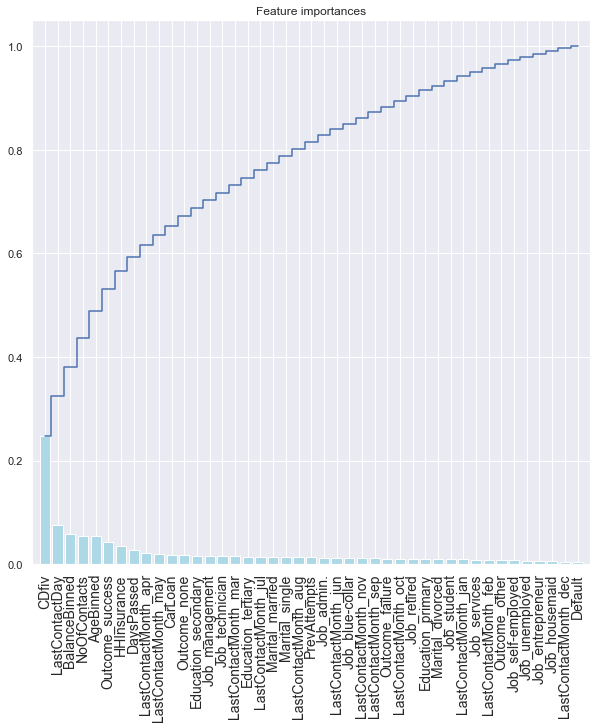

In [35]:
#Feature importance - from manibhask
# Using ExtraTreesClassifier model function
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# Calcualting important features in the model
importances = model.feature_importances_
feat_names = df.drop(['CarInsurance'],axis=1).columns

# Displaying the feature importances as a chart by sorting it in the order of importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()